<a href="https://colab.research.google.com/github/Koelgeetkaur26/Bouhadjar-2023-synapse-model/blob/main/Bouhadjar_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Comparing Synapse Models from Bouhadjar et al. (2023)**

**Project Overview**

This notebook implements and simulates the core concepts from the 2023 paper, "Sequence learning in a spiking neuronal network with memristive synapses" (Bouhadjar et al.).

The paper explores how memristive synapses can be used for on-chip, brain-inspired sequence learning. A key challenge in neuromorphic hardware is endurance and energy consumption: memristive devices can "wear out" after too many physical write operations.

**The Two Models**

The paper investigates two different synapse architectures to solve this, which we will simulate and compare:

- The Analog Model: This is a "write-on-every-event" model. It performs a small, gradual, physical write (and consumes energy) for every single STDP learning event. While functionally simple, this approach would lead to massive write counts and high energy use.

- The Binary Model: This is the paper's "smart," hardware-friendly solution. It uses a "virtual notepad" (which the paper calls Permanence, P) to track learning events in low-power digital logic. A high-energy "physical write" is only committed once this virtual value crosses a set threshold (e.g., P > 10).

**Goal of this Notebook**

The purpose of this simulation is to implement both models and run them through the same A->B->C sequence learning task for 50 episodes. We will then compare their:

- Learning Accuracy: Do both models successfully learn the sequence?

- Hardware Cost: What is the final, total cost in physical writes (endurance) and energy consumption (pJ) for each model?

This comparison will allow us to quantify the efficiency gains of the "virtual notepad" approach.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:


class MemristorPhysicsModel:
    """
    A Python-based model of memristor physics.
    This replaces the ngspice simulation.
    """
    def __init__(self, g_min=1e-6, g_max=100e-6, v_set=1.2, v_reset=-1.0, k_speed=500.0):
        self.g_min = g_min # min conductance
        self.g_max = g_max # max conductance
        self.v_set = v_set # set voltage to 1.2V. Any pulse value greater than 1.2 V is considered "STRONG"
        self.v_reset = v_reset # reset voltage to -1. Any pulse value more negative than -1.0 V is considered "WEAK"
        self.k_speed = k_speed # defines how fast the strength of the synapse changes.

    ##----physics engine for our project----## #defines the energy comsumption if memristor is at g_initial and hit with a pulse of v_pulse for t_pulse_ns#
    # also defines what is the change in strength, delta_g #
    def get_pulse_physics(self, v_pulse, t_pulse_ns, g_initial):
        """
        Simulates a single pulse and returns the
        change in conductance (delta_g) and energy cost.
        """
        g_current = g_initial
        t_pulse_s = t_pulse_ns * 1e-9

        # --- Calculate Energy ---
        r_current = 1.0 / g_current
        i_pulse = v_pulse / r_current
        p_pulse_watts = v_pulse * i_pulse
        energy_joules = p_pulse_watts * t_pulse_s
        total_energy_pj = energy_joules * 1e12

        # --- Calculate Change in Conductance (Delta G) ---
        delta_g = 0.0
        if v_pulse > self.v_set:
            v_over = v_pulse - self.v_set
            delta_g = self.k_speed * v_over * t_pulse_s
        elif v_pulse < self.v_reset:
            v_over = v_pulse - self.v_reset
            delta_g = self.k_speed * v_over * t_pulse_s

        g_final = np.clip(g_current + delta_g, self.g_min, self.g_max)
        final_delta_g = g_final - g_initial

        return final_delta_g, total_energy_pj

def generate_lut(model):
    """
    Sweeps pulse parameters to create the "price list" (LUT).
    """
    print("Generating 'Price List' (LUT) from Python hardware model...")
    pulse_table = {}
    g_mid = (model.g_max + model.g_min) / 2.0

    set_voltages = [1.3, 1.5, 1.8]
    pulse_widths_ns = [5, 10, 20]
    for v in set_voltages:
        for t_ns in pulse_widths_ns:
            delta_g, energy = model.get_pulse_physics(v, t_ns, g_mid)
            if delta_g > 0:
                pulse_table[f'set_{v}V_{t_ns}ns'] = {'delta_g': delta_g, 'energy': energy}

    reset_voltages = [-1.2, -1.4, -1.6]
    for v in reset_voltages:
        for t_ns in pulse_widths_ns:
            delta_g, energy = model.get_pulse_physics(v, t_ns, g_mid)
            if delta_g < 0:
                pulse_table[f'reset_{abs(v)}V_{t_ns}ns'] = {'delta_g': delta_g, 'energy': energy}

    print("LUT Generation complete.")

    set_pulses = sorted(
        [(v['delta_g'], v['energy'], k) for k, v in pulse_table.items() if v['delta_g'] > 0]
    )
    reset_pulses = sorted(
        [(abs(v['delta_g']), v['energy'], k) for k, v in pulse_table.items() if v['delta_g'] < 0]
    )

    return pulse_table, set_pulses, reset_pulses


In [12]:
# --- DYNAMICALLY GENERATE THE "PRICE LIST" ---
# This code runs *once* at the beginning of our script.
hardware_model = MemristorPhysicsModel()
PULSE_LOOKUP_TABLE, SET_PULSES, RESET_PULSES = generate_lut(hardware_model)

Generating 'Price List' (LUT) from Python hardware model...
LUT Generation complete.


In [13]:
# THE SYNAPSE MODELS
# We define TWO types of synapses:
# 1. AnalohSynapse: Writes to hardware on *every* call.
# 2. BinarySynapse: Uses the "notepad" (self.P) and only writes
#    when the threshold is crossed.

def find_best_pulse(E_val): ## finds the best/closest pulse based on the strength value ##

    if E_val > 0: # Need a SET pulse
        if not SET_PULSES: return 0, 0
        pulses = SET_PULSES
        target_delta_g = E_val
    else: # Need a RESET pulse
        if not RESET_PULSES: return 0, 0
        pulses = RESET_PULSES
        target_delta_g = abs(E_val)

    best_pulse = min(pulses, key=lambda p: abs(p[0] - target_delta_g))
    delta_g, energy, _ = best_pulse

    return (delta_g if E_val > 0 else -delta_g), energy



In [14]:
class AnalogSynapse:
   ## It writes to hardware on *every* call to potentiate/depress ##
    def __init__(self):
        self.G = hardware_model.g_min  # Physical Conductance
        self.total_energy_pj = 0.0
        self.total_writes = 0

    def get_conductance(self):
        return self.G

    def potentiate(self, A_pot_val):
        ## Strengthen the synapse. This is a PHYSICAL write.##
        delta_g, energy = find_best_pulse(A_pot_val)

        self.G = np.clip(self.G + delta_g, hardware_model.g_min, hardware_model.g_max)
        self.total_energy_pj += energy
        self.total_writes += 1

    def depress(self, A_dep_val):
        ## Weaken the synapse. This is a PHYSICAL write.##
        delta_g, energy = find_best_pulse(A_dep_val)

        self.G = np.clip(self.G + delta_g, hardware_model.g_min, hardware_model.g_max)
        self.total_energy_pj += energy
        self.total_writes += 1

    #def step_decay(self):
     #   pass # Naive model has no notepad to decay

   # def check_and_commit(self):
    #    pass # Naive model commits instantly, so no check is needed

In [15]:
class BinarySynapse:
    ## It uses a "notepad" (self.P) to track virtual changes and only performs a physical write when a threshold is crossed ##

    def __init__(self, commit_threshold=10.0, P_max=20.0, dt=1.0):
        # --- Physical State ---
        self.G = hardware_model.g_min  # Physical Conductance

        # --- Virtual State (The "Notepad", paper's "Permanence")
        self.P = 0.0              # Permanence ("Notepad")
        self.P_max = P_max        # Max value for the notepad
        self.commit_threshold = commit_threshold # Paper's theta_P (10.0)

        # --- Logging ---
        self.total_energy_pj = 0.0
        self.total_writes = 0

    def get_conductance(self):
        return self.G

    def potentiate(self, A_pot_val):
        ## Jot a 'strengthen' note on the notepad. Does NOT write yet.This is a VIRTUAL write (Eq. 3) ##

        # We use a simplified +1 for potentiate, -0.4 for depress
        # to match the "dip-and-reinforce" trace.
        delta_P = 1.0 # This is a simplified "potentiate" value
        self.P = np.clip(self.P + delta_P, 0, self.P_max)
        self.check_and_commit() # Check if this virtual write triggers a commit

    def depress(self, A_dep_val):
        ## Jot a 'weaken' note on the notepad. Does NOT write yet.This is a VIRTUAL write (Eq. 3)##

        delta_P = -0.4 # This is a simplified "depress" value
        self.P = np.clip(self.P + delta_P, 0, self.P_max)
        self.check_and_commit() # Check if this virtual write triggers a commit

    def step_decay(self):
        ## The paper's Permanence model (Eq. 3) does not decay.##
        pass

    def check_and_commit(self):
        ## This is the "COMMIT MOMENT" logic (Eq. 2).Checks if the notepad has crossed the threshold and flips G.##

        # --- This is the "LUT Check" (Eq. 2) ---
        if self.P >= self.commit_threshold:
            # We need to be in the "ON" state
            if self.G == hardware_model.g_min: # Only write if we are currently OFF
                # --- This is the PHYSICAL COMMIT (G_min -> G_max)
                self.G = hardware_model.g_max

                # Find a pulse that causes a SET (strengthen)
                # We pass a small positive value to find_best_pulse
                _, energy = find_best_pulse(1e-6)

                self.total_energy_pj += energy
                self.total_writes += 1

        elif self.P < self.commit_threshold:
            # We need to be in the "OFF" state
            if self.G == hardware_model.g_max: # Only write if we are currently ON
                # --- This is the PHYSICAL COMMIT (G_max -> G_min) ---
                self.G = hardware_model.g_min

                # Find a pulse that causes a RESET (weaken)
                # We pass a small negative value to find_best_pulse
                _, energy = find_best_pulse(-1e-6)

                self.total_energy_pj += energy
                self.total_writes += 1

In [16]:
class SpikingNetwork:
    ## Implements the full SNN simulation,this class is the "Brain" and "Controller"##

    def __init__(self, sequence, n_clubs, neurons_per_club, mode='Binary'):
        # Network Structure
        self.sequence = sequence
        self.n_clubs = n_clubs
        self.neurons_per_club = neurons_per_club
        self.n_neurons = n_clubs * neurons_per_club
        self.mode = mode

        # Neuron Model Parameters (LIF)
        self.V_thresh = -55.0
        self.V_reset = -75.0
        self.V_rest = -65.0
        self.tau_m = 10.0
        self.tau_syn = 5.0
        self.R_m = 10.0

        # STDP Learning Rule Parameters
        self.plasticity_window_min = 4.0
        self.plasticity_window_max = 50.0

        # NOTE: These values are now only used by the AnalogSynapse
        self.A_pot = 1.0e-6    # Potentiation amount (like "+3")
        self.A_dep = -0.4e-6   # Depression amount (like "-1")

        # Simulation Parameters
        self.dt = 1.0  # Use 1.0ms dt for faster simulation
        self.inter_stim_interval = 50.0 # Time between inputs
        self.stim_duration = 5.0
        self.I_input = 20.0 # Input current (calibrated to make neurons fire)

        # State Variables
        self.V = np.full(self.n_neurons, self.V_rest)
        self.I_syn = np.zeros(self.n_neurons)
        self.last_spike_time = np.full(self.n_neurons, -np.inf)

        # --- Create the synapse "crossbar" ---
        # we fill the 2D list with the correct synapse *type* based on self.mode #
        print(f"\n--- Running simulation in {self.mode} mode ---")
        print(f"Initializing {self.n_neurons}x{self.n_neurons} synapse grid...")

        self.synapses = [[None for _ in range(self.n_neurons)]
                              for _ in range(self.n_neurons)]

        if self.mode == 'Binary':
            # Set the commit threshold to be 10.0, as in the paper
            commit_thresh_binary = 10.0
            print(f"Binary Commit Threshold (theta_P) set to: {commit_thresh_binary}")
            for i in range(self.n_neurons):
                for j in range(self.n_neurons):
                    # We pass the threshold to the synapse
                    self.synapses[i][j] = BinarySynapse(commit_thresh_binary, dt=self.dt)
        else: # 'Analog' mode
            print("Analog mode: Commit threshold is 0.")
            for i in range(self.n_neurons):
                for j in range(self.n_neurons):
                    self.synapses[i][j] = AnalogSynapse()

        print("Synapse grid created.")

    def _get_club_indices(self, club_id):
        # Helper function to get neuron indices for a given club #
        start = club_id * self.neurons_per_club
        end = start + self.neurons_per_club
        return range(start, end)

    def run_simulation(self, n_episodes):
        # Runs the main training simulation #
        print(f"Running simulation for {n_episodes} episodes...")

        # --- Prepare Logging ---
        log_G_AB = [] # Synapse from A to B
        log_G_BC = [] # Synapse from B to C
        log_G_AC = [] # Synapse from A to C (should not learn)

        for ep in range(n_episodes): # Repeat the sequence many times

            self.V.fill(self.V_rest)
            self.I_syn.fill(0.0)
            self.last_spike_time.fill(-np.inf)

            current_stim_club = -1
            stim_timer = 0.0

            total_time = self.inter_stim_interval * len(self.sequence) + 100.0
            time_steps = int(total_time / self.dt)

            for t_idx in range(time_steps):
                t = t_idx * self.dt

                # --- Handle Input (Presenting 'A', then 'B', then 'C') ---
                I_in = np.zeros(self.n_neurons)
                if t % self.inter_stim_interval < self.dt:
                    current_stim_club += 1
                    if current_stim_club < len(self.sequence):
                        stim_timer = self.stim_duration

                if stim_timer > 0:
                    if current_stim_club < len(self.sequence):
                        club_id = self.sequence[current_stim_club]
                        I_in[self._get_club_indices(club_id)] = self.I_input
                    stim_timer -= self.dt

                # --- Update Neuron Dynamics
                dV = (-(self.V - self.V_rest) + self.R_m * self.I_syn) / self.tau_m
                self.V = self.V + dV * self.dt + I_in * self.dt
                self.I_syn = self.I_syn * np.exp(-self.dt / self.tau_syn)

                # --- Firing and STDP Logic
                spiked_neurons = np.where(self.V > self.V_thresh)[0]

                if len(spiked_neurons) > 0:
                    for i in spiked_neurons: # i is POST-synaptic
                        for j in range(self.n_neurons): # j is PRE-synaptic
                            time_diff = t - self.last_spike_time[j]

                            # This is the "pre-post" event (A->B)
                            if (time_diff > self.plasticity_window_min and
                                time_diff < self.plasticity_window_max):
                                # Pass the *value* to the synapse
                                # This value is now ignored by BinarySynapse,
                                # but still used by AnalogSynapse
                                self.synapses[i][j].potentiate(self.A_pot)

                        self.V[i] = self.V_reset
                        self.last_spike_time[i] = t

                    for j in spiked_neurons: # j is PRE-synaptic
                        for i in range(self.n_neurons):
                            if i != j:
                                # This is the "pre-only" event
                                # Pass the *value* to the synapse
                                self.synapses[i][j].depress(self.A_dep)

                        # Propagate the spike current
                        for i in range(self.n_neurons):
                            self.I_syn[i] += self.synapses[i][j].get_conductance()


            log_G_AB.append(np.mean([self.synapses[i][j].get_conductance()
                                        for i in self._get_club_indices(1)
                                        for j in self._get_club_indices(0)]))
            log_G_BC.append(np.mean([self.synapses[i][j].get_conductance()
                                        for i in self._get_club_indices(2)
                                        for j in self._get_club_indices(1)]))
            log_G_AC.append(np.mean([self.synapses[i][j].get_conductance()
                                        for i in self._get_club_indices(2)
                                        for j in self._get_club_indices(0)]))

            if (ep + 1) % 10 == 0:
                print(f"  Episode {ep + 1}/{n_episodes} complete.")

        print("Simulation finished.")
        return {
            'time': np.arange(n_episodes) * total_time / 1000.0, # Time in seconds
            'G_AB': log_G_AB,
            'G_BC': log_G_BC,
            'G_AC': log_G_AC,
        }

    def get_total_energy(self):
        # Iterates all synapses to get final energy #

        total_energy = 0.0
        total_writes = 0
        write_hist = []
        for i in range(self.n_neurons):
            for j in range(self.n_neurons):
                syn = self.synapses[i][j]
                total_energy += syn.total_energy_pj
                total_writes += syn.total_writes
                write_hist.append(syn.total_writes)

        return total_energy, total_writes, np.array(write_hist)



--- Running simulation in Analog mode ---
Initializing 15x15 synapse grid...
Analog mode: Commit threshold is 0.
Synapse grid created.
Running simulation for 50 episodes...
  Episode 10/50 complete.
  Episode 20/50 complete.
  Episode 30/50 complete.
  Episode 40/50 complete.
  Episode 50/50 complete.
Simulation finished.

--- Running simulation in Binary mode ---
Initializing 15x15 synapse grid...
Binary Commit Threshold (theta_P) set to: 10.0
Synapse grid created.
Running simulation for 50 episodes...
  Episode 10/50 complete.
  Episode 20/50 complete.
  Episode 30/50 complete.
  Episode 40/50 complete.
  Episode 50/50 complete.
Simulation finished.

Generating plots...


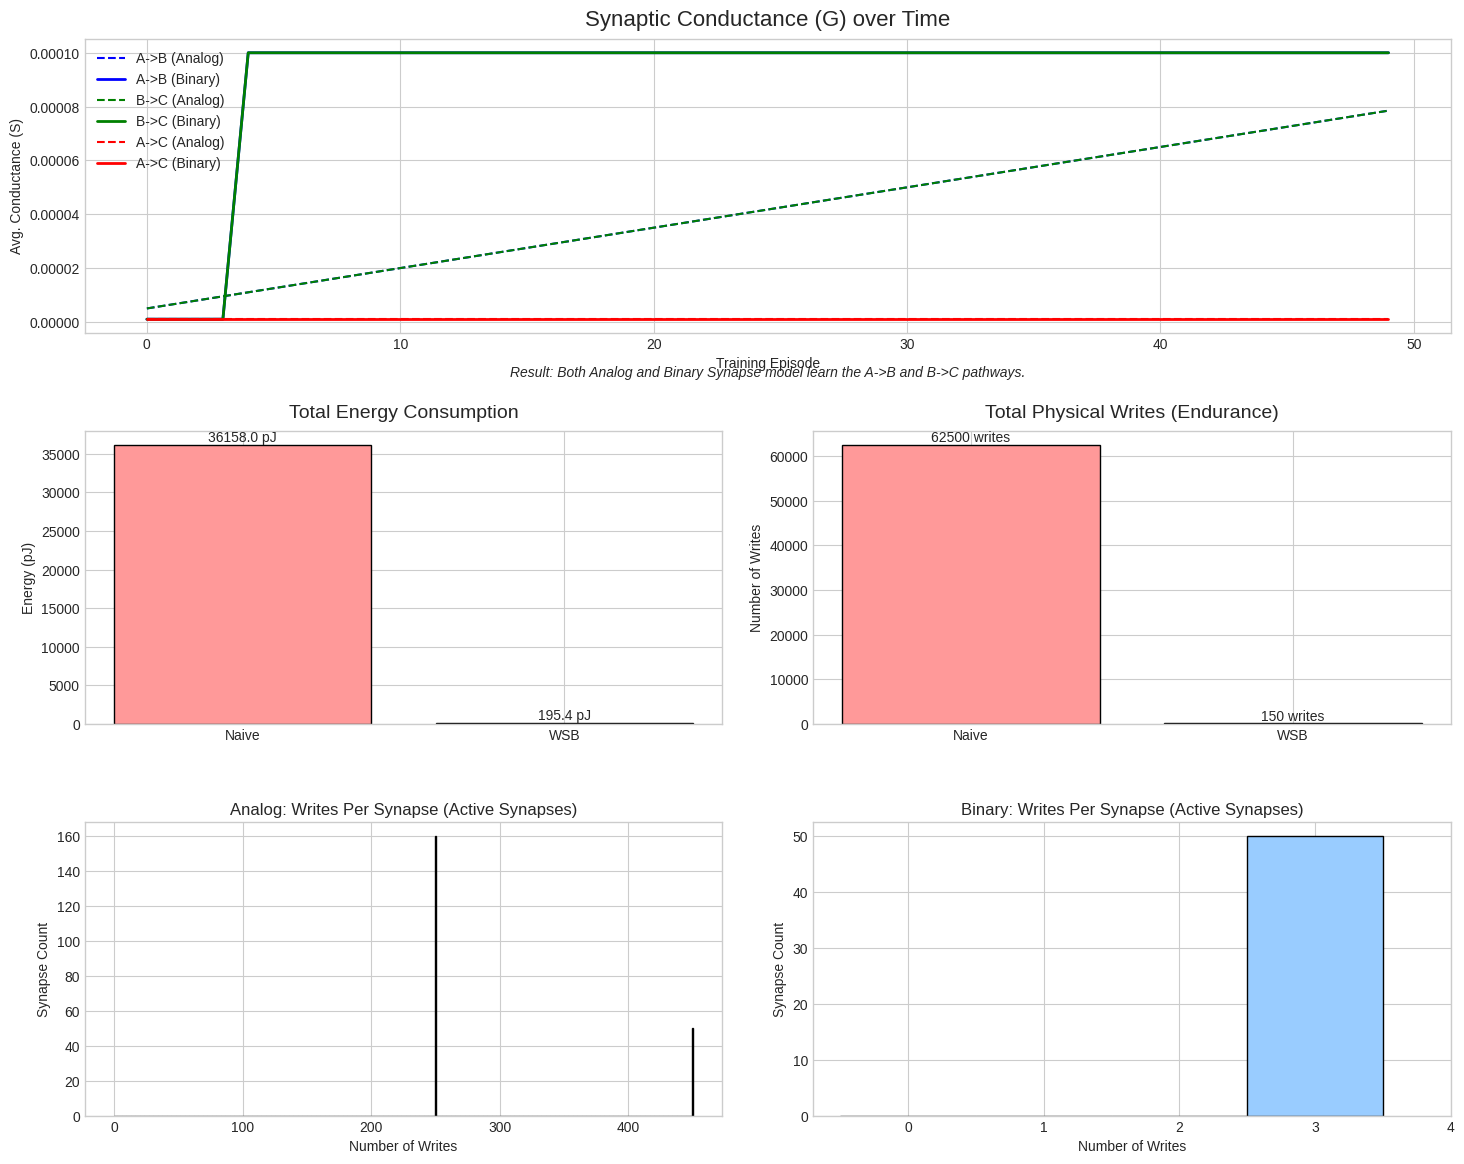


--- Experiment Analysis ---
Energy Saved: 99.5%
Writes Saved: 99.8%


In [17]:
# This is the main script that runs the Analog vs Binary, runs the experiment and plots the comparison.


if __name__ == "__main__":

    # --- Experiment Setup
    sequence_to_learn = [0, 1, 2] # "A->B->C"
    n_clubs = 3
    neurons_per_club = 5 # Small network for speed
    n_episodes = 50 # Train for 50 episodes

    # --- Run 1: Analog Mode
    network_analog = SpikingNetwork(sequence_to_learn, n_clubs, neurons_per_club, mode='Analog')
    data_analog = network_analog.run_simulation(n_episodes=n_episodes)
    E_analog, W_analog, H_analog = network_analog.get_total_energy()

    # --- Run 2: Binary Mode
    network_binary = SpikingNetwork(sequence_to_learn, n_clubs, neurons_per_club, mode='Binary')
    data_binary = network_binary.run_simulation(n_episodes=n_episodes)
    E_binary, W_binary, H_binary = network_binary.get_total_energy()

    # --- Create Plots ---
    print("\nGenerating plots...")

    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except:
        plt.style.use('seaborn-whitegrid')

    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 2)

    colors = ['#FF9999', '#99CCFF']

    # --- Plot 1: Conductance Evolution (Top Row) ---
    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(data_analog['G_AB'], label='A->B (Analog)', linestyle='--', c='blue')
    ax0.plot(data_binary['G_AB'], label='A->B (Binary)', linestyle='-', c='blue', lw=2)
    ax0.plot(data_analog['G_BC'], label='B->C (Analog)', linestyle='--', c='green')
    ax0.plot(data_binary['G_BC'], label='B->C (Binary)', linestyle='-', c='green', lw=2)
    ax0.plot(data_analog['G_AC'], label='A->C (Analog)', linestyle='--', c='red')
    ax0.plot(data_binary['G_AC'], label='A->C (Binary)', linestyle='-', c='red', lw=2)

    ax0.set_title('Synaptic Conductance (G) over Time', fontsize=16, pad=10)
    ax0.set_xlabel('Training Episode')
    ax0.set_ylabel('Avg. Conductance (S)')
    ax0.legend(loc='upper left')
    ax0.text(0.5, -0.15, "Result: Both Analog and Binary Synapse model learn the A->B and B->C pathways.",
             transform=ax0.transAxes, ha='center', style='italic')

    # --- Plot 2: Bar Plots (Energy & Writes)
    ax1 = fig.add_subplot(gs[1, 0])
    modes = ['Naive', 'WSB']
    energies = [E_analog, E_binary]

    bars = ax1.bar(modes, energies, color=colors, edgecolor='black')
    ax1.set_title('Total Energy Consumption', fontsize=14, pad=10)
    ax1.set_ylabel('Energy (pJ)')
    ax1.bar_label(bars, fmt='%.1f pJ')

    ax2 = fig.add_subplot(gs[1, 1])
    writes = [W_analog, W_binary]
    bars = ax2.bar(modes, writes, color=colors, edgecolor='black')
    ax2.set_title('Total Physical Writes (Endurance)', fontsize=14, pad=10)
    ax2.set_ylabel('Number of Writes')
    ax2.bar_label(bars, fmt='%d writes')

    # --- Plot 3: Writes per Synapse Histogram
    ax3 = fig.add_subplot(gs[2, 0])
    hist_analog = H_analog[H_analog > 0] # Filter out the 0s for a cleaner plot
    if len(hist_analog) == 0: hist_analog = np.array([0])
    # Dynamically set bins to be integers
    bins_naive = np.arange(0, hist_analog.max() + 2) - 0.5
    ax3.hist(hist_analog, bins=bins_naive, color=colors[0], edgecolor='black')
    ax3.set_title('Analog: Writes Per Synapse (Active Synapses)')
    ax3.set_xlabel('Number of Writes')
    ax3.set_ylabel('Synapse Count')
    if hist_analog.max() > 0 and hist_analog.max() < 20:
         ax3.set_xticks(range(0, int(hist_analog.max()) + 2))

    ax4 = fig.add_subplot(gs[2, 1])
    hist_wsb = H_binary[H_binary > 0] # Filter out the 0s for a cleaner plot
    if len(hist_wsb) == 0: hist_wsb = np.array([0])
    # Dynamically set bins to be integers
    bins_wsb = np.arange(0, hist_wsb.max() + 2) - 0.5
    ax4.hist(hist_wsb, bins=bins_wsb, color=colors[1], edgecolor='black')
    ax4.set_title('Binary: Writes Per Synapse (Active Synapses)')
    ax4.set_xlabel('Number of Writes')
    ax4.set_ylabel('Synapse Count')
    if hist_wsb.max() > 0 and hist_wsb.max() < 20:
        ax4.set_xticks(range(0, int(hist_wsb.max()) + 2))


    plt.tight_layout(pad=2.0)
    plt.show()

    print("\n--- Experiment Analysis ---")
    if E_analog > 0:
        print(f"Energy Saved: {100 * (1 - E_binary / E_analog):.1f}%")
    else:
        print("Energy Saved: N/A (Analog mode used 0 energy)")

    if W_analog > 0:
        print(f"Writes Saved: {100 * (1 - W_binary / W_analog):.1f}%")
    else:
        print("Writes Saved: N/A (Naive mode had 0 writes)")



**Conclusions**

This simulation was designed to compare two different synapse models for learning the sequence A->B->C, based on the architectures presented in Bouhadjar et al. (2023):

Analog Model: Performs a small, gradual, physical write for every learning event.

Binary Model: Uses a "virtual notepad" (Permanence) and only performs a single, abrupt physical write when a "commit" threshold is crossed.

The results from our 50-episode simulation clearly and decisively show the advantages of the Binary model.

1. Learning Accuracy: As we can see from the first graph, the "Synaptic Conductance vs. Time" graph shows that both models successfully learned the sequence.

- Correct Pathways (A->B, B->C): The blue and green lines show that both models strengthened these connections. The Analog model (dashed line) climbed gradually, while the Binary model (solid line) "committed" and jumped abruptly to its maximum strength (G_max) after a few episodes.

- Incorrect Pathway (A->C): The red lines for both models remain flat at zero. This proves the STDP logic was successful in "pruning" unused connections.

2. Writes & Energy: The bar charts show the total cost for the entire 50-episode simulation.

- Physical Writes (Endurance): As seen the Analog model required 62,500 physical writes to gradually learn the sequence while on the other hand, the Binary model, by doing all its work "virtually," required only 150 physical writes (a 99.8% reduction). This is a monumental saving in device endurance.

- Energy Consumption: This endurance saving translates directly to energy. As seen the Analog model cost 36,158 pJ, while the Binary model cost only 195.4 pJ (a 99.5% reduction).

3. The number of writes per synapse

- Analog Model: The active synapses were "hammered" with hundreds of writes each (spikes at ~250 and ~450 writes). This is the source of the high cost and is unsustainable for real hardware.

- Binary Model: The 50 active synapses (A->B and B->C) were written to exactly 3 times each. This represents the "wobble" as the virtual value crossed the threshold (1: Commit ON, 2: Dip OFF, 3: Re-commit ON). All other synapses in the network had zero writes.

Thus we can say that the analog implementation of STDP is functionally correct but practically unfeasible due to the massive energy and endurance cost of writing on every event.

On the other hand the Binary Synapse Model is the clear solution. By separating the "virtual" learning (P) from the "physical" state (G), it achieves the exact same learning result but with a 99.8% reduction in physical writes. This proves it is a robust, energy-efficient, and hardware-viable model for on-chip neuromorphic learning.